In [ ]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# Load data
#get the data
df = pd.read_csv("/content/LTC-USD.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-26,273.108002,289.510986,272.261993,286.503998,286.503998,842993024
1,2017-12-27,286.588989,290.944000,264.423004,272.174011,272.174011,777137984
2,2017-12-28,272.126007,273.177002,231.376999,249.929993,249.929993,2593240064
3,2017-12-29,250.352005,258.040985,238.332993,245.501999,245.501999,1392210048
4,2017-12-30,245.087006,245.432999,208.197006,218.962997,218.962997,943667008
...,...,...,...,...,...,...,...
1822,2022-12-22,65.399422,66.514549,64.517052,66.151672,66.151672,368489876
1823,2022-12-23,66.152802,66.596397,65.450348,65.772224,65.772224,306694378
1824,2022-12-24,65.772232,66.012245,65.263176,65.774788,65.774788,178396939
1825,2022-12-25,65.774750,69.363144,65.540604,69.206268,69.206268,335124962


In [ ]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['Close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['Close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['Close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['Close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['Close'].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv("/content/LTC-USD.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,2018-01-15,237.289001,245.003998,232.774002,232.774002,232.774002,601769984,12.229996,4.514999,242.059858,251.912857,250.522952,10.612533,20.588468
21,2018-01-16,232.817001,232.817001,152.292999,188.330994,188.330994,1405069952,80.524002,44.486007,233.673285,247.101928,245.848047,22.529358,23.012990
22,2018-01-17,190.145004,197.789993,141.007004,186.516006,186.516006,1422489984,56.782989,3.628998,224.530143,242.898214,241.769095,27.081103,25.563445
23,2018-01-18,186.949005,207.016006,176.830002,192.837006,192.837006,936784000,30.186004,-5.888001,219.311715,239.431572,239.050381,29.413042,27.606452
24,2018-01-19,191.192001,202.074997,186.938004,192.964005,192.964005,560284032,15.136993,-1.772004,213.041430,235.409644,236.548572,29.726382,29.319971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2022-12-22,65.399422,66.514549,64.517052,66.151672,66.151672,368489876,1.997497,-0.752250,65.209958,70.512904,73.074049,1.036008,5.932171
1823,2022-12-23,66.152802,66.596397,65.450348,65.772224,65.772224,306694378,1.146049,0.380578,65.130733,69.758451,72.494084,0.954354,6.026096
1824,2022-12-24,65.772232,66.012245,65.263176,65.774788,65.774788,178396939,0.749069,-0.002556,65.247433,69.001579,71.978697,0.979315,6.119666
1825,2022-12-25,65.774750,69.363144,65.540604,69.206268,69.206268,335124962,3.822540,-3.431518,65.912024,68.471452,71.597363,1.725026,6.025892


In [ ]:
pre_day = 30
#feature scaling (MinMax Scaler)
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))

cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['Close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))
#Split the data into x_train and y_train data sets
x_total = []
y_total = []
#create a loop of values
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])
#Splitting the dataset
test_size = (int)(len(scaled_data_y) * 0.1)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

180
(1597, 30, 7) (1597, 1) (180, 30, 7) (180, 1)


In [ ]:
# Build model
model = Sequential()
#5 layers lstm, and first lstm connect input information
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))
#trainning model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, steps_per_epoch=40, use_multiprocessing=True)

Epoch 1/100
40/40 [==============================] - 16s 105ms/step - loss: 0.0087
Epoch 2/100
40/40 [==============================] - 4s 108ms/step - loss: 0.0062
Epoch 3/100
40/40 [==============================] - 4s 106ms/step - loss: 0.0063
Epoch 4/100
40/40 [==============================] - 4s 107ms/step - loss: 0.0051
Epoch 5/100
40/40 [==============================] - 4s 108ms/step - loss: 0.0045
Epoch 6/100
40/40 [==============================] - 4s 109ms/step - loss: 0.0042
Epoch 7/100
40/40 [==============================] - 5s 130ms/step - loss: 0.0039
Epoch 8/100
40/40 [==============================] - 4s 108ms/step - loss: 0.0041
Epoch 9/100
40/40 [==============================] - 4s 107ms/step - loss: 0.0032
Epoch 10/100
40/40 [==============================] - 4s 108ms/step - loss: 0.0027
Epoch 11/100
40/40 [==============================] - 4s 108ms/step - loss: 0.0024
Epoch 12/100
40/40 [==============================] - 4s 106ms/step - loss: 0.0023
Epoch 13/100

In [ ]:
# Testing
predict_price = model.predict(x_test)
predict_price = scala_y.inverse_transform(predict_price)

6/6 [==============================] - 2s 23ms/step


(180, 1)


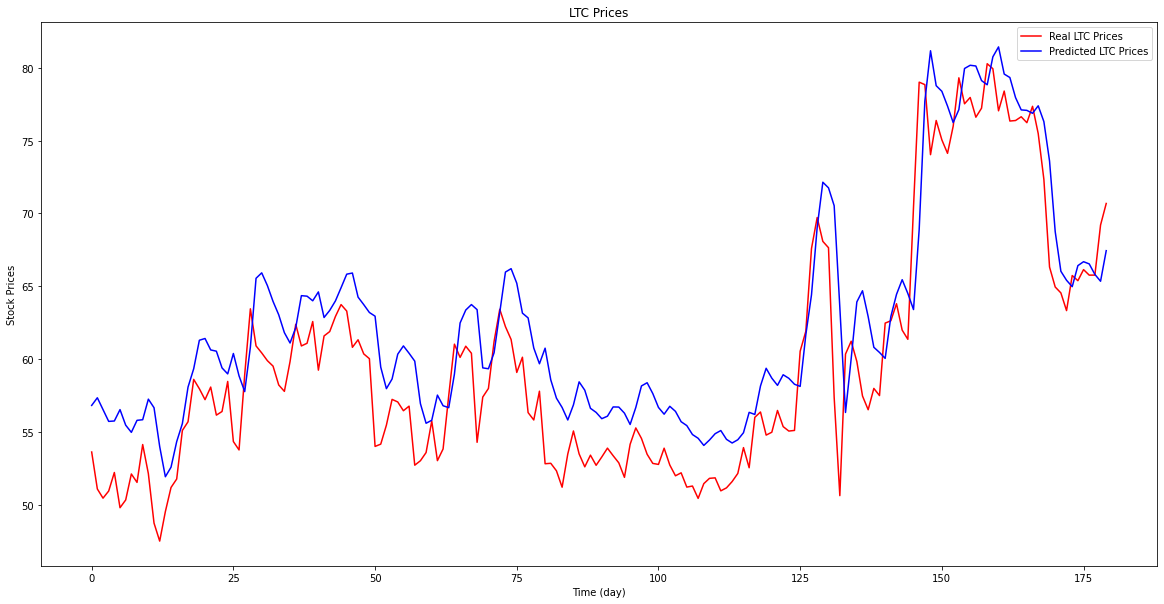

In [ ]:
# Ploting the stat
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1,1)
real_price = np.array(real_price)
print(real_price.shape)
real_price = real_price.reshape(real_price.shape[0], 1)

plt.figure(figsize=(20,10))
plt.plot(real_price, color="red", label=f"Real LTC Prices") # real price line
plt.plot(predict_price, color="blue", label=f"Predicted LTC Prices") # predict_price line
plt.title(f"LTC Prices") # naming chart
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.legend() #note
plt.show()

In [ ]:
# Make Prediction
x_predict = df[len(df)-pre_day:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scala_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))

prediction = model.predict(x_predict)
prediction = scala_y.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 25ms/step
[[69.483795]]


In [ ]:
mae = mean_absolute_error(real_price, predict_price)
mape = mean_absolute_percentage_error(real_price, predict_price)
mse = mean_squared_error(real_price, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 3.36
MAPE: 5.86%
MSE: 16.12
RMSE: 4.02
R2: 0.75
